<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>

**What?** Predict electricity consumption over 5 yrs using ARIMA 

# Instructions
<hr style="border:2px solid black"> </hr>

- You are provided with a daily energy consumption data of UK in a data file.
- The time series dataset contains 5 years history.
- You are asked to forecast energy demand for next 12-months period.

# Observations
<hr style="border:2px solid black"> </hr>

- The task asks for the next 12-months prediction but, it does not impose a frequency.
- Every ML task has two basics components: experts and the ML part. In this assignment the experts are not presents and most of the work presented here is the result of personal choices, thus it is open to both interpretation and misunderstanding of the problem at hand.

# Execution instructions
<hr style="border:2px solid black"> </hr>

- Assuming you have `conda` install, it would be sufficient to install a clean virtual environment with a python 3.x version, this is all you need to be able to run this notebook. Of course, `conda` is not necessary, this is just what I have used.
- Additionally the following packages must be installed:
    - `pip install pandas`
    - `pip install matplotlib`
    - `pip install numpy`
    - `pip install statsmodels=0.12.2`

# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
# Suppres warnings if any
import warnings
warnings.filterwarnings('ignore')

# Data wrangling
import numpy as np
import pandas as pd

# Modelling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Plotting
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
import statsmodels
# Must be 0.12.2
statsmodels.__version__

'0.12.2'

# Read-in the dataset
<hr style="border:2px solid black"> </hr>

In [3]:
df = pd.read_csv('../data/energy.dat')

In [4]:
df.head(5)

,Date,Consumption
0,01-Apr-15,357.073
1,02-Apr-15,341.931
2,03-Apr-15,318.777
3,04-Apr-15,312.494
4,05-Apr-15,270.837


In [5]:
df.tail(5)

,Date,Consumption
1822,27-Mar-20,237.171
1823,28-Mar-20,229.744
1824,29-Mar-20,297.636
1825,30-Mar-20,323.811
1826,31-Mar-20,277.821


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1827 non-null   object 
 1   Consumption  1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB


# EDA
<hr style="border:2px solid black"> </hr>

- Exploratory design analysis: get the feeling of the data.

## Early vs. monthly trend

- How does the yearly trend look like? We can most definetly see some oscillation that follow an yearly trend.
- There seems to be a downward trend for both, mean, max and min energy consumption.

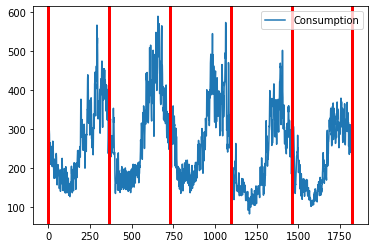

In [7]:
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 16, 5
df.plot()
for i in range(6):
    plt.axvline(x=[365*i], color='r', linestyle="-", lw=3)

- The trend for the month of April shows enough variability in the data. This could be considered noise, change in temperature or bank holiday event.
- The real reason cannot be known at this stage.

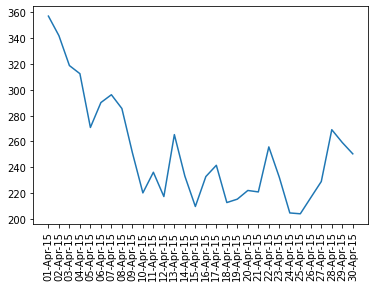

In [8]:
plt.plot(df["Date"][:30], df["Consumption"][:30])
plt.xticks(rotation=90);

## Rolling mean

- This section offers a way to visualise what happens if a rolling mean over some steps is chosen.
- In the case below a month-long is chosen, here chosen to be a standard 30 days (although this is not precise).
- If we were use it instead of the original timeseries, the trend would much more smooth and we are missing the peaks and valleys.
- While modelling we have to decide what we want to model: trend along with its noisy or only trend. Of course, I am making the big assumption here that the high-frequency variations can be considered noise.
- Because of the limited data available on the task, I'd rather concentrate on predicting a steady and reliable trend rather than trying to model each single peaks. 

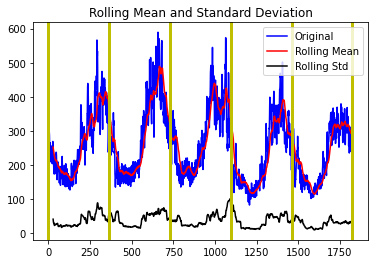

In [9]:
timeseries = df["Consumption"]
step = 30

# Determing rolling statistics
rolmean = timeseries.rolling(step).mean()
rolstd = timeseries.rolling(step).std()
# Plot rolling statistics:
plt.plot(timeseries, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
for i in range(6):
    plt.axvline(x=[365*i], color='y', linestyle="-", lw=3)
plt.show(block=False)

## Dickey-Fuller test

- The DF test is a statistical test used to established if the timeseries is stationary or no.
- For both cases (daily and monthly trend) the timeseries is not stationary.
- For stationary we'd like to say `p-value<<0.05`.

### Daily

In [10]:
adft = adfuller(df['Consumption'], autolag='AIC')
output = pd.Series(adft[0:4], index=[
                   'Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
for key, values in adft[4].items():
    output['critical value (%s)' % key] = values
print(output)

Test Statistics                  -2.642058
p-value                           0.084612
No. of lags used                 24.000000
Number of observations used    1802.000000
critical value (1%)              -3.433984
critical value (5%)              -2.863145
critical value (10%)             -2.567625
dtype: float64


### Monthly

In [11]:
adft = adfuller(df['Consumption'][::30], autolag='AIC')
output = pd.Series(adft[0:4], index=[
                   'Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
for key, values in adft[4].items():
    output['critical value (%s)' % key] = values
print(output)

Test Statistics                -0.593445
p-value                         0.872456
No. of lags used               10.000000
Number of observations used    50.000000
critical value (1%)            -3.568486
critical value (5%)            -2.921360
critical value (10%)           -2.598662
dtype: float64


## Decomposition

- The timeseries can be decomposed in its trend and seasonal component. Plus a residual is plotted.
- This is repeated for both daily and monthly frequencies with the goal to see that if sampling every 30 days would have drastically changed the series. That does not seem to be the case.

### Daily

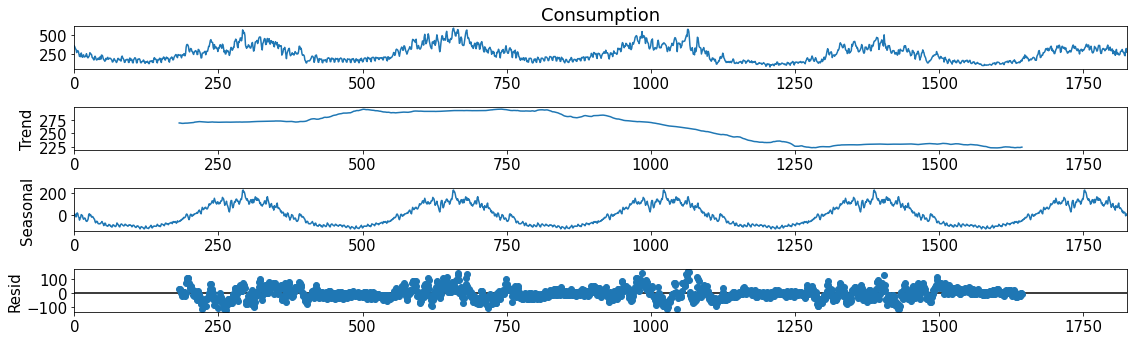

In [12]:
rcParams['figure.figsize'] = 16, 5
rcParams['font.size'] = 15

result = seasonal_decompose(df["Consumption"], model='additive', period=365)
result.plot()
plt.show()

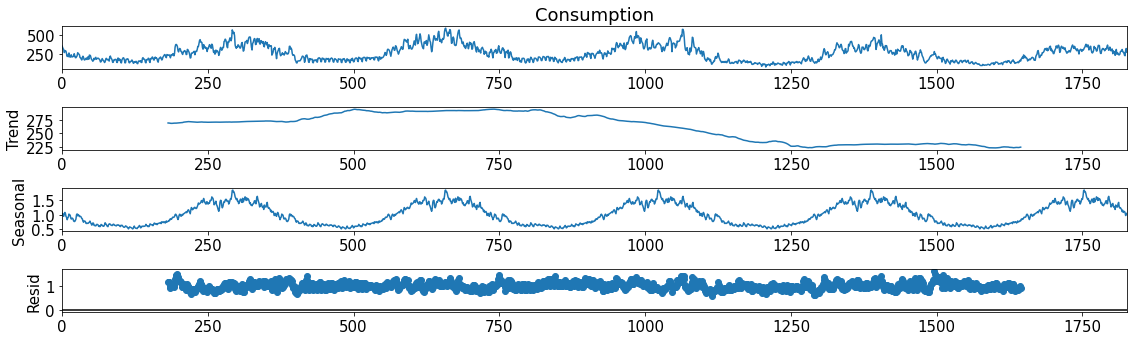

In [13]:
rcParams['figure.figsize'] = 16, 5
rcParams['font.size'] = 15

result = seasonal_decompose(df["Consumption"], model='multiplicative', period=365)
result.plot()
plt.show()

## Monthly

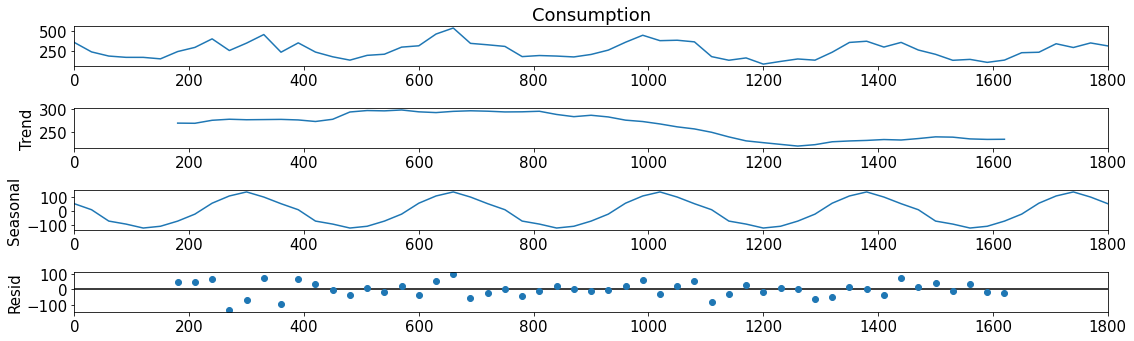

In [14]:
rcParams['figure.figsize'] = 16, 5
rcParams['font.size'] = 15

result = seasonal_decompose(df["Consumption"][::30], model='additive', period=12)
result.plot()
plt.show()

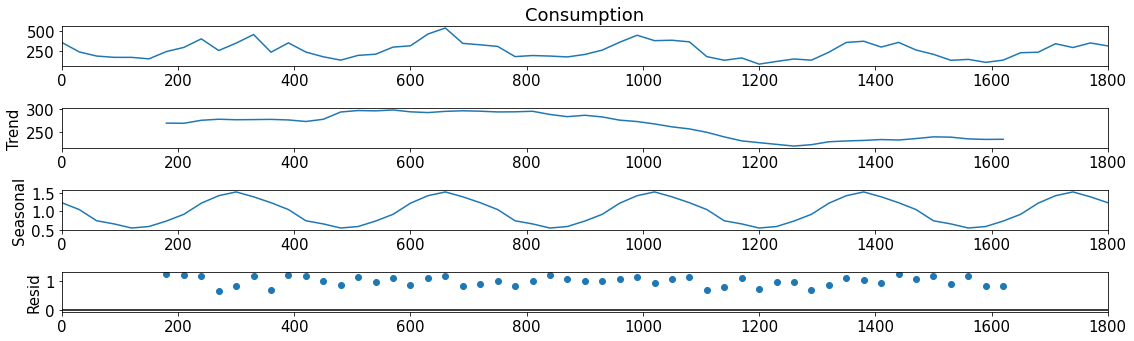

In [15]:
rcParams['figure.figsize'] = 16, 5
rcParams['font.size'] = 15

result = seasonal_decompose(df["Consumption"][::30], model='multiplicative', period=12)
result.plot()
plt.show()

# Correlation
<hr style="border:2px solid black"> </hr>

- The right order of differencing is the **minimum** differencing required to get a **near-stationary** series which **roams around** a defined mean and the ACF plot reaches to zero **fairly quick**. If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. If the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced. In this case `d=1` would be enough in both daily and monthly cases.

- **p** is the number of lag observations included in the model, also called the lag order. You can find out the p value by inspecting the **Partial Autocorrelation** (PACF) plot. **Partial autocorrelation** can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

- **q**: is the size of the moving average window, also called the order of moving average. Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast. The ACF tells how many MA terms are required to remove any autocorrelation in the series.

## ACF - daily

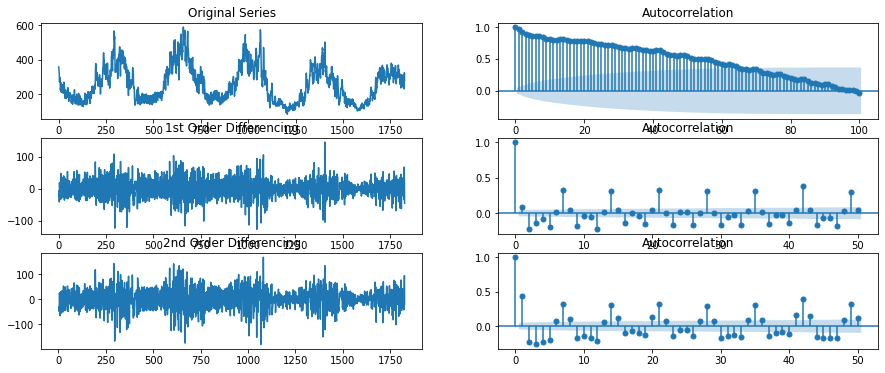

In [16]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 10

# Original Series
seq = df["Consumption"]

fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(seq); 
axes[0, 0].set_title('Original Series')
plot_acf(seq, lags=100, ax=axes[0, 1])

# 1st Differencing
seq = df["Consumption"]
axes[1, 0].plot(seq.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(seq.diff().dropna(), lags=50, ax=axes[1, 1])

# 2nd Differencing
seq = df["Consumption"]
axes[2, 0].plot(seq.diff(2));
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(seq.diff(2).dropna(), lags=50, ax=axes[2, 1])

plt.show()

## ACF - monthly

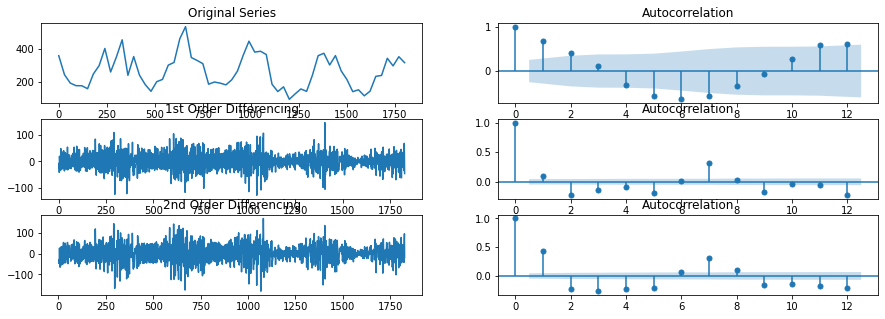

In [17]:
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 10

# Original Series
seq = df["Consumption"][::30]

fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(seq); 
axes[0, 0].set_title('Original Series')
plot_acf(seq, lags=12, ax=axes[0, 1])

# 1st Differencing
seq = df["Consumption"]
axes[1, 0].plot(seq.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(seq.diff().dropna(), lags=12, ax=axes[1, 1])

# 2nd Differencing
seq = df["Consumption"]
axes[2, 0].plot(seq.diff(2));
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(seq.diff(2).dropna(), lags=12, ax=axes[2, 1])

plt.show()

## PACF - daily

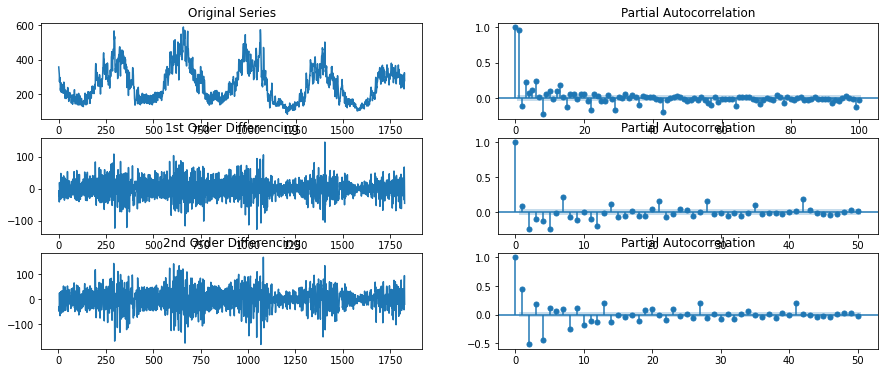

In [18]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 10

# Original Series
seq = df["Consumption"]

fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(seq); 
axes[0, 0].set_title('Original Series')
plot_pacf(seq, lags=100, ax=axes[0, 1])
#axes[0, 0].set_xlim([0,365*12])
#axes[0, 1].set_xlim([0,100])

# 1st Differencing
seq = df["Consumption"]
axes[1, 0].plot(seq.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_pacf(seq.diff().dropna(), lags=50, ax=axes[1, 1])
#axes[1, 0].set_xlim([0,100])

# 2nd Differencing
seq = df["Consumption"]
axes[2, 0].plot(seq.diff(2));
axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(seq.diff(2).dropna(), lags=50, ax=axes[2, 1])
#axes[2, 0].set_xlim([0,100])

plt.show()

## PACF - monthly

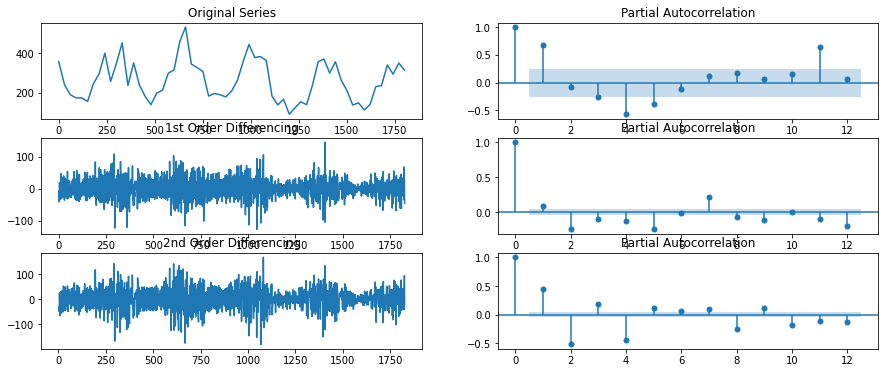

In [19]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 10

# Original Series
seq = df["Consumption"][::30]

fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(seq); 
axes[0, 0].set_title('Original Series')
plot_pacf(seq, lags=12, ax=axes[0, 1])
#axes[0, 0].set_xlim([0,365*12])
#axes[0, 1].set_xlim([0,100])

# 1st Differencing
seq = df["Consumption"]
axes[1, 0].plot(seq.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_pacf(seq.diff().dropna(), lags=12, ax=axes[1, 1])
#axes[1, 0].set_xlim([0,100])

# 2nd Differencing
seq = df["Consumption"]
axes[2, 0].plot(seq.diff(2));
axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(seq.diff(2).dropna(), lags=12, ax=axes[2, 1])
#axes[2, 0].set_xlim([0,100])

plt.show()

# Modelling
<hr style="border:2px solid black"> </hr>

- ARIMA is based on the idea that the information in the past can alone be used to predict the future values. This is a big assumption and other factor are most definitely at play in timeseries forecasting. 

- It is a generalization of the simpler AutoRegressive Moving Average:
    - **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations. A pure Auto Regressive (AR only) model is one where a value depends only on its own lags.
    - **I**: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary. 
    - **MA**: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations. A pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.
- So what does ARIMA model do? An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. 

In [20]:
# Taking value at each month
df = df[::30]

In [21]:
df

,Date,Consumption
0,01-Apr-15,357.073
30,01-May-15,241.180
60,31-May-15,190.412
90,30-Jun-15,174.610
120,30-Jul-15,174.327
...,...,...
1680,06-Nov-19,237.046
1710,06-Dec-19,341.189
1740,05-Jan-20,295.117
1770,04-Feb-20,350.927


In [22]:
len(df.index)

61

In [23]:
forecast_length = round(len(df.index)/5)
print(forecast_length)

12


In [24]:
forecast_length

12

In [25]:
df

,Date,Consumption
0,01-Apr-15,357.073
30,01-May-15,241.180
60,31-May-15,190.412
90,30-Jun-15,174.610
120,30-Jul-15,174.327
...,...,...
1680,06-Nov-19,237.046
1710,06-Dec-19,341.189
1740,05-Jan-20,295.117
1770,04-Feb-20,350.927


## In-sample fit

In [26]:
train = df[:-forecast_length]
test = df[-forecast_length:]

In [27]:
train.values

array([['01-Apr-15', 357.07300000000004],
       ['01-May-15', 241.18],
       ['31-May-15', 190.412],
       ['30-Jun-15', 174.61],
       ['30-Jul-15', 174.327],
       ['29-Aug-15', 156.16899999999998],
       ['28-Sep-15', 245.547],
       ['28-Oct-15', 296.409],
       ['27-Nov-15', 401.119],
       ['27-Dec-15', 258.113],
       ['26-Jan-16', 348.968],
       ['25-Feb-16', 453.80300000000005],
       ['26-Mar-16', 237.59900000000002],
       ['25-Apr-16', 351.89],
       ['25-May-16', 239.138],
       ['24-Jun-16', 181.364],
       ['24-Jul-16', 140.398],
       ['23-Aug-16', 199.02],
       ['22-Sep-16', 212.81099999999998],
       ['22-Oct-16', 299.73900000000003],
       ['21-Nov-16', 316.07599999999996],
       ['21-Dec-16', 460.11800000000005],
       ['20-Jan-17', 533.945],
       ['19-Feb-17', 345.858],
       ['21-Mar-17', 328.265],
       ['20-Apr-17', 308.536],
       ['20-May-17', 183.62599999999998],
       ['19-Jun-17', 196.821],
       ['19-Jul-17', 190.285999999999

- A nonseasonal ARIMA model is classified as an `ARIMA(p,d,q)` model, where:
    - p is the number of autoregressive terms, look at the ACF plot
    - d is the number of nonseasonal differences needed for stationarity, look at the PACF plot
    - q is the number of lagged forecast errors in the prediction equation.

In [28]:
model = ARIMA(train["Consumption"], order = (7, 1, 1))  
fitted = model.fit(disp=0) 

- The P-Value in `P>|z|` should ideally be less than `0.05` for the respective X to be significant.
- I understand that the value plotted under are not ideal, but I feel this is the best model I could come up with given the time I had. I am however, **flagging this out**.

In [29]:
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Consumption   No. Observations:                   48
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -265.145
Method:                       css-mle   S.D. of innovations             57.635
Date:                Sat, 18 Feb 2023   AIC                            550.291
Time:                        11:36:17   BIC                            569.003
Sample:                             1   HQIC                           557.362
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.1935      1.215     -0.982      0.326      -3.575       1.188
ar.L1.D.Consumption     0.1818      0.179      1.014      0.311      -0.170       0.533
ar.L2.D.Consumpt

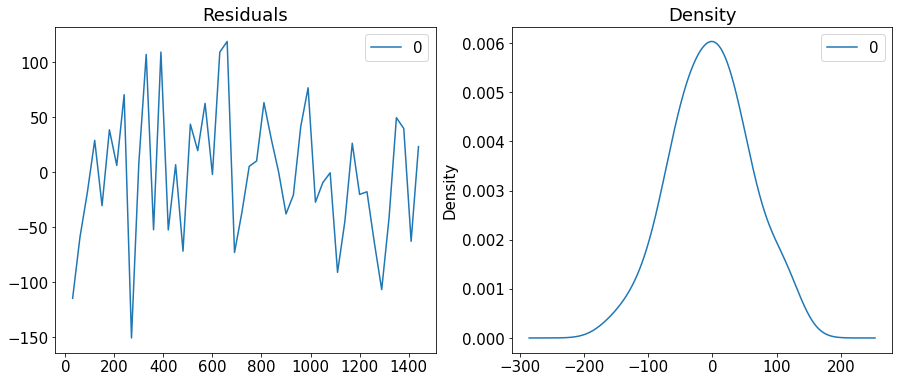

In [30]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 15

residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## In-sample prediction

- **dynamic=False** then in-sample lagged values are used for prediction.
- That is, the model gets trained up until the previous value to make the next prediction. 
- This can make the fitted forecast and actuals look artificially good.

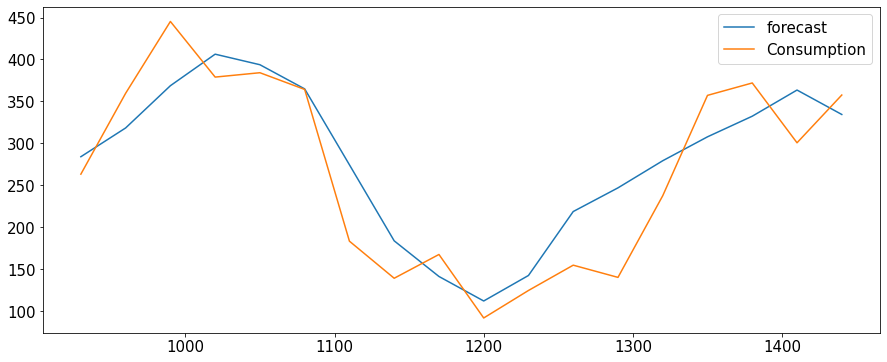

In [31]:
fitted.plot_predict(dynamic=False)
plt.show()

## In-sample forecasting

In [32]:
# Forecast with a 95% confidence band
fc, se, conf = fitted.forecast(forecast_length, alpha=0.05)

In [33]:
# Make a pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

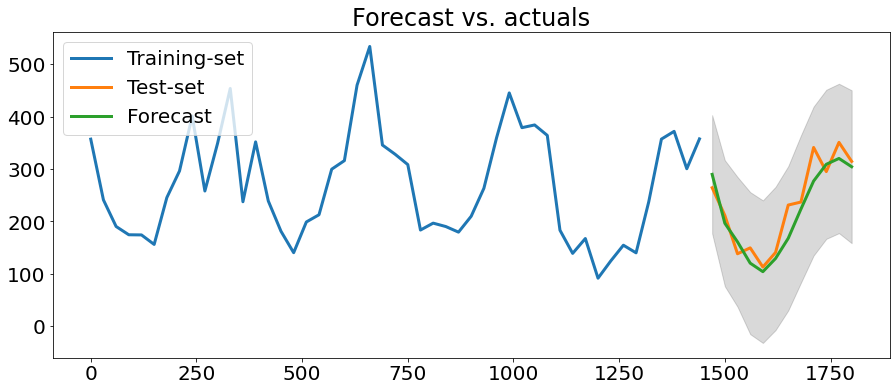

In [34]:
# Plot
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 20

plt.figure()
plt.plot(train["Consumption"], lw=3, label='Training-set')
plt.plot(test["Consumption"], lw=3, label='Test-set')
plt.plot(fc_series, lw=3, label='Forecast')

plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs. actuals')
plt.legend(loc='upper left')
plt.show()

### Accuracy metrcs

- Generally **only** MAPE, correlationa and Min-Max error are used becasuse they are expressed in percentage.
- The other metrics are here reported just in case.

In [35]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    acf1 = acf(forecast-actual)[1]              # ACF1
    return ({'mape': mape,
            'me': me,
             'mae': mae,
             'mpe': mpe,
             'rmse': rmse,
             'acf1': acf1,
             'corr': corr,
             'minmax': minmax})

In [36]:
forecast = fc_series.values
actual = test["Consumption"].values

forecast_accuracy(forecast, actual)

{'mape': 0.11432519187778113,
 'me': -15.345105495883402,
 'mae': 25.707320612612317,
 'mpe': -0.06303357834458294,
 'rmse': 31.62701273612726,
 'acf1': -0.31502350013603964,
 'corr': 0.9384309355120279,
 'minmax': 0.11151647429167033}

## Out-of-sample forecasting

In [37]:
# This time we are feeding the whole series
train = df

In [38]:
model = ARIMA(train["Consumption"], order = (7, 1, 1))  
fitted = model.fit(disp=0) 

In [39]:
# Forecast with a 95% confidence band
fc, se, conf = fitted.forecast(forecast_length, alpha=0.05)

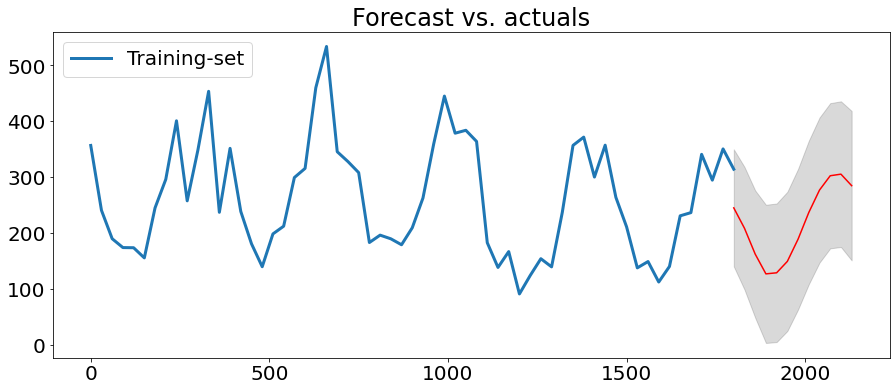

In [40]:
# Plot
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 20

plt.figure()
plt.plot(train["Consumption"], lw=3, label='Training-set')

last = train["Consumption"].index[-1]

plt.plot([last+30*(i) for i in range(12)], fc, "r")

plt.fill_between([last+30*(i) for i in range(12)], conf[:, 0], conf[:, 1],
                 color='k', alpha=.15)

plt.title('Forecast vs. actuals')
plt.legend(loc='upper left')
plt.show()

# Conclusions
<hr style="border:2px solid black"> </hr>

- The model trained in this task is not perfect and offer only a baseline upon which many improvements can be made. In particulars, the most important feature actions would be:
    - Although, I have decided to work on a monthly basis data rather than on a daily basis, this is not said to have been the interviewers original request.
    - Working on a daily forecast would require much more feature engineering thinking, such as keeping track of bank holiday and  extreme weather prediction.
    - SARIMA with its seasonal component could offer some advantages here.
    - The ARIMA-family model are parametric and a non-parametric model, such as boosted tree could prove advantageous here.